EDA 토대로 이상치거나 분석하기 좋지 않다고 판단 한 데이터 제거>

In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/부동산실습/train.csv')

In [ ]:
# 이상치 제거
data = data[data['관리비'] != 96]
data = data[data['총주차대수']!=590]

In [ ]:
# 결측치 확인
data.isnull().sum()

,0
ID,0
매물확인방식,0
보증금,0
월세,0
전용면적,786
해당층,227
총층,16
방향,0
방수,16
욕실수,18


Categorical Feature를 전처리 해줘야함
<br>나중에 결측치 imputation Categorical Feature를 넣기 위함  

In [ ]:
# 중앙값처리
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def processing(train):
  # Train과 Test 불러오고 합치기
  x = train.drop(['ID','허위매물여부'],axis=1)
  y = train['허위매물여부']

  label_encode_cols = ['제공플랫폼', '방향', '게재일','중개사무소']

  # Label Encoding 진행
  for col in label_encode_cols:
    le = LabelEncoder()
    x[col] = le.fit_transform(x[col].astype(str))  # Label Encoding

  # One-Hot Encoding 적용 열
  one_hot_cols = ['매물확인방식', '주차가능여부']
  # One-Hot Encoding 적용
  one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  # Train 데이터 변환
  x_encoded = one_hot_encoder.fit_transform(x[one_hot_cols])
  x_encoded_df = pd.DataFrame(x_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=x.index)
  # 기존 데이터와 병합
  x = pd.concat([x.drop(columns=one_hot_cols), x_encoded_df], axis=1)
  return x , y

In [ ]:
# 결측치 실험을 위한 함수
X_train , y_train = processing(data)

 Numerical Featrue [ 전용면적, 해당층, 총층, 방수, 욕실 수, 총 주차대수]에 결측값 존재

결측치 처리
1. 중앙값 대체
2. modeling 대체
3. under sampling ( 결측치 있는 feature 삭제 )
<br>중앙값 대체와 모데링 대체 선택
<br>실험 중앙값 대체 vs regression imputation vs Mice imputation<br>
이때 regression과 Mice는 (numerical + categorcial)과 (numerical)도 비교함

In [ ]:
X_train

,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,총주차대수,관리비,중개사무소,제공플랫폼,게재일,매물확인방식_서류확인,매물확인방식_전화확인,매물확인방식_현장확인,주차가능여부_가능,주차가능여부_불가능
1,170500000.0,200000,NaN,3.0,4.0,0,2.0,1.0,NaN,0,228,3,472,0.0,0.0,1.0,0.0,1.0
2,114000000.0,380000,NaN,2.0,3.0,3,1.0,1.0,NaN,0,150,0,444,0.0,1.0,0.0,0.0,1.0
3,163500000.0,30000,36.30,3.0,9.0,0,2.0,1.0,13.0,10,31,0,442,0.0,0.0,1.0,1.0,0.0
4,346000000.0,530000,NaN,3.0,3.0,3,2.0,1.0,NaN,0,72,1,288,0.0,0.0,1.0,0.0,1.0
5,153000000.0,530000,29.50,NaN,3.0,2,2.0,1.0,1.0,0,87,0,367,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,159000000.0,550000,48.95,3.0,3.0,2,2.0,1.0,NaN,0,162,1,432,1.0,0.0,0.0,0.0,1.0
2448,158500000.0,750000,NaN,2.0,4.0,2,1.0,1.0,NaN,2,174,0,391,1.0,0.0,0.0,0.0,1.0
2449,329000000.0,610000,17.50,8.0,20.0,1,1.0,1.0,29.0,10,31,1,248,0.0,1.0,0.0,1.0,0.0
2450,31000000.0,400000,22.87,8.0,9.0,0,2.0,1.0,NaN,8,207,1,330,0.0,0.0,1.0,1.0,0.0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

def imputation(method, data, feature_columns):
    if feature_columns =='num':
       list_numerical_columns = ['보증금', '월세', '전용면적', '해당층', '총층', '방수','총주차대수','욕실수','관리비']
       train_data, test_data = train_test_split(data[list_numerical_columns].dropna(), test_size=0.2, random_state=42)

    elif feature_columns =="num_cat":
       train_data, test_data = train_test_split(data.dropna(), test_size=0.2, random_state=42)

    missing_columns = ['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']
    test_data_missing = test_data.copy()
    for col in missing_columns:
        test_data_missing.loc[test_data_missing.sample(frac=0.2).index, col] = np.nan

    results = {}

    if method == 'regression':
        for column in missing_columns:
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            X_train = train_data.dropna(subset=[column]).drop(columns=[column])
            y_train = train_data.dropna(subset=[column])[column]

            rf.fit(X_train, y_train)

            missing_indices = test_data_missing.index[test_data_missing[column].isnull()]
            X_missing = test_data_missing.loc[missing_indices].drop(columns=[column])

            if not X_missing.empty:
                test_data_missing.loc[missing_indices, column] = rf.predict(X_missing)

            original_missing_values = test_data.loc[missing_indices, column]
            imputed_values = test_data_missing.loc[missing_indices, column]

            results[column] = {
                'Final RMSE': np.sqrt(mean_squared_error(original_missing_values, imputed_values)),
                'Final MAE': mean_absolute_error(original_missing_values, imputed_values),
                'Model': rf
            }

    elif method == 'mice':
        mice_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42), max_iter=10)
        mice_imputer.fit(train_data)
        test_data_imputed = pd.DataFrame(mice_imputer.transform(test_data_missing), columns=test_data_missing.columns, index=test_data_missing.index)

        for column in missing_columns:
            missing_indices = test_data_missing.index[test_data_missing[column].isnull()]
            original_missing_values = test_data.loc[missing_indices, column]
            imputed_values = test_data_imputed.loc[missing_indices, column]

            results[column] = {
                'Final RMSE': np.sqrt(mean_squared_error(original_missing_values, imputed_values)),
                'Final MAE': mean_absolute_error(original_missing_values, imputed_values)
            }

    elif method == 'median':
        median_imputer = SimpleImputer(strategy="median")
        median_imputer.fit(train_data)
        test_data_imputed = pd.DataFrame(median_imputer.transform(test_data_missing), columns=test_data_missing.columns, index=test_data_missing.index)

        for column in missing_columns:
            missing_indices = test_data_missing.index[test_data_missing[column].isnull()]
            original_missing_values = test_data.loc[missing_indices, column]
            imputed_values = test_data_imputed.loc[missing_indices, column]

            results[column] = {
                'Final RMSE': np.sqrt(mean_squared_error(original_missing_values, imputed_values)),
                'Final MAE': mean_absolute_error(original_missing_values, imputed_values)
            }

    return results

In [ ]:
def print_results(results):
    print("\n🔹 결측치 대체 성능 비교 🔹\n")
    for col, scores in results.items():
        print(f"▶ {col}:")
        print(f"   - RMSE: {scores['Final RMSE']:.2f}")
        print(f"   - MAE: {scores['Final MAE']:.2f}\n")

In [ ]:
print_results(imputation('regression', X_train, 'num'))


🔹 결측치 대체 성능 비교 🔹

▶ 전용면적:
   - RMSE: 7.03
   - MAE: 6.19

▶ 총주차대수:
   - RMSE: 16.90
   - MAE: 12.81

▶ 해당층:
   - RMSE: 3.16
   - MAE: 2.21

▶ 욕실수:
   - RMSE: 0.23
   - MAE: 0.08

▶ 총층:
   - RMSE: 4.74
   - MAE: 3.63

▶ 방수:
   - RMSE: 0.39
   - MAE: 0.29



In [ ]:
print_results(imputation('regression', X_train, 'num_cat'))


🔹 결측치 대체 성능 비교 🔹

▶ 전용면적:
   - RMSE: 6.26
   - MAE: 5.25

▶ 총주차대수:
   - RMSE: 19.46
   - MAE: 12.57

▶ 해당층:
   - RMSE: 3.39
   - MAE: 2.38

▶ 욕실수:
   - RMSE: 0.24
   - MAE: 0.07

▶ 총층:
   - RMSE: 4.28
   - MAE: 3.20

▶ 방수:
   - RMSE: 0.33
   - MAE: 0.20



In [ ]:
print_results(imputation('median', X_train,'num'))


🔹 결측치 대체 성능 비교 🔹

▶ 전용면적:
   - RMSE: 8.19
   - MAE: 6.55

▶ 총주차대수:
   - RMSE: 22.42
   - MAE: 15.67

▶ 해당층:
   - RMSE: 4.06
   - MAE: 2.71

▶ 욕실수:
   - RMSE: 0.24
   - MAE: 0.06

▶ 총층:
   - RMSE: 5.60
   - MAE: 4.67

▶ 방수:
   - RMSE: 0.54
   - MAE: 0.29



In [ ]:
print_results(imputation('median', X_train,'num_cat'))


🔹 결측치 대체 성능 비교 🔹

▶ 전용면적:
   - RMSE: 8.10
   - MAE: 6.77

▶ 총주차대수:
   - RMSE: 30.02
   - MAE: 20.00

▶ 해당층:
   - RMSE: 3.67
   - MAE: 2.86

▶ 욕실수:
   - RMSE: 0.20
   - MAE: 0.04

▶ 총층:
   - RMSE: 5.80
   - MAE: 5.08

▶ 방수:
   - RMSE: 0.64
   - MAE: 0.41



In [ ]:
print_results(imputation('mice', X_train, 'num'))


🔹 결측치 대체 성능 비교 🔹

▶ 전용면적:
   - RMSE: 8.28
   - MAE: 6.52

▶ 총주차대수:
   - RMSE: 19.84
   - MAE: 14.38

▶ 해당층:
   - RMSE: 3.64
   - MAE: 2.55

▶ 욕실수:
   - RMSE: 0.09
   - MAE: 0.03

▶ 총층:
   - RMSE: 4.68
   - MAE: 3.60

▶ 방수:
   - RMSE: 0.40
   - MAE: 0.27



In [ ]:
print_results(imputation('mice', X_train, 'num_cat'))


🔹 결측치 대체 성능 비교 🔹

▶ 전용면적:
   - RMSE: 7.39
   - MAE: 5.69

▶ 총주차대수:
   - RMSE: 14.80
   - MAE: 12.14

▶ 해당층:
   - RMSE: 3.71
   - MAE: 2.60

▶ 욕실수:
   - RMSE: 0.23
   - MAE: 0.09

▶ 총층:
   - RMSE: 5.00
   - MAE: 3.94

▶ 방수:
   - RMSE: 0.38
   - MAE: 0.25



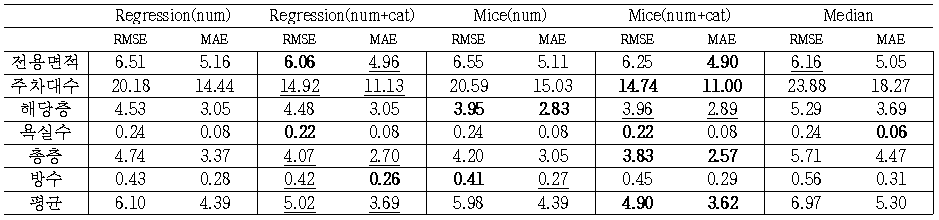

실험 결과 결측치 대체의 경우 MICE(num+cat)으로 하기로 결정함  

In [ ]:
# train_test data 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def processing(train, test):
  # Train과 Test 불러오고 합치기
  x = train.drop(['ID','허위매물여부'],axis=1)
  y = train['허위매물여부']
  x_test = test.drop(['ID'],axis=1)
  label_encode_cols = ['제공플랫폼', '방향','중개사무소','게재일']

  for col in label_encode_cols:
    le = LabelEncoder()
    # 🚀 Train 데이터에서 LabelEncoder 학습
    x[col] = le.fit_transform(x[col].astype(str))
    # 🚀 새로운 값 예외 처리 (Test 데이터에서 Train에 없는 값은 -1로 변환)
    x_test[col] = x_test[col].astype(str).apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

  # One-Hot Encoding 적용 열
  one_hot_cols = ['매물확인방식', '주차가능여부']
  # One-Hot Encoding 적용
  one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
  # Train 데이터 변환
  x_encoded = one_hot_encoder.fit_transform(x[one_hot_cols])
  x_test_encoded = one_hot_encoder.transform(x_test[one_hot_cols])

  x_encoded_df = pd.DataFrame(x_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=x.index)
  x_test_encoded_df =  pd.DataFrame(x_test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=x_test.index)
  # 기존 데이터와 병합
  x = pd.concat([x.drop(columns=one_hot_cols), x_encoded_df], axis=1)
  x_test = pd.concat([x_test.drop(columns=one_hot_cols), x_test_encoded_df], axis=1)
  return x ,y, x_test

In [ ]:
# 실제 결측치 처리 코드
from sklearn.experimental import enable_iterative_imputer  # MICE 사용을 위해 필요
from sklearn.impute import IterativeImputer  # 이제 import 가능
from sklearn.ensemble import RandomForestRegressor

# 결측치 impute
def impute(train,test):
  train_column = train.columns
  test_column = test.columns
  missing_columns = ['전용면적', '총주차대수', '해당층', '욕실수', '총층', '방수']

  # 📌 3. MICE Imputation 적용 (Train 데이터로 학습 후, Test 데이터에 적용)
  mice_imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=100, random_state=42), max_iter=10)

  # 결측치 넣기
  train_data_imputed = pd.DataFrame(mice_imputer.fit_transform(train), columns=train_column)
  test_data_imputed = pd.DataFrame(mice_imputer.transform(test), columns=test_column)

  return train_data_imputed, test_data_imputed

In [ ]:
import pandas as pd
# X_train X_test 선언
data = pd.read_csv('/content/drive/MyDrive/부동산실습/train.csv')
test = pd.read_csv('/content/drive/MyDrive/부동산실습/test.csv')
data = data[data['관리비'] != 96]
data = data[data['총주차대수']!=590]
X_train , y_train , X_test = processing(data, test)
X_train, X_test = impute(X_train , X_test)

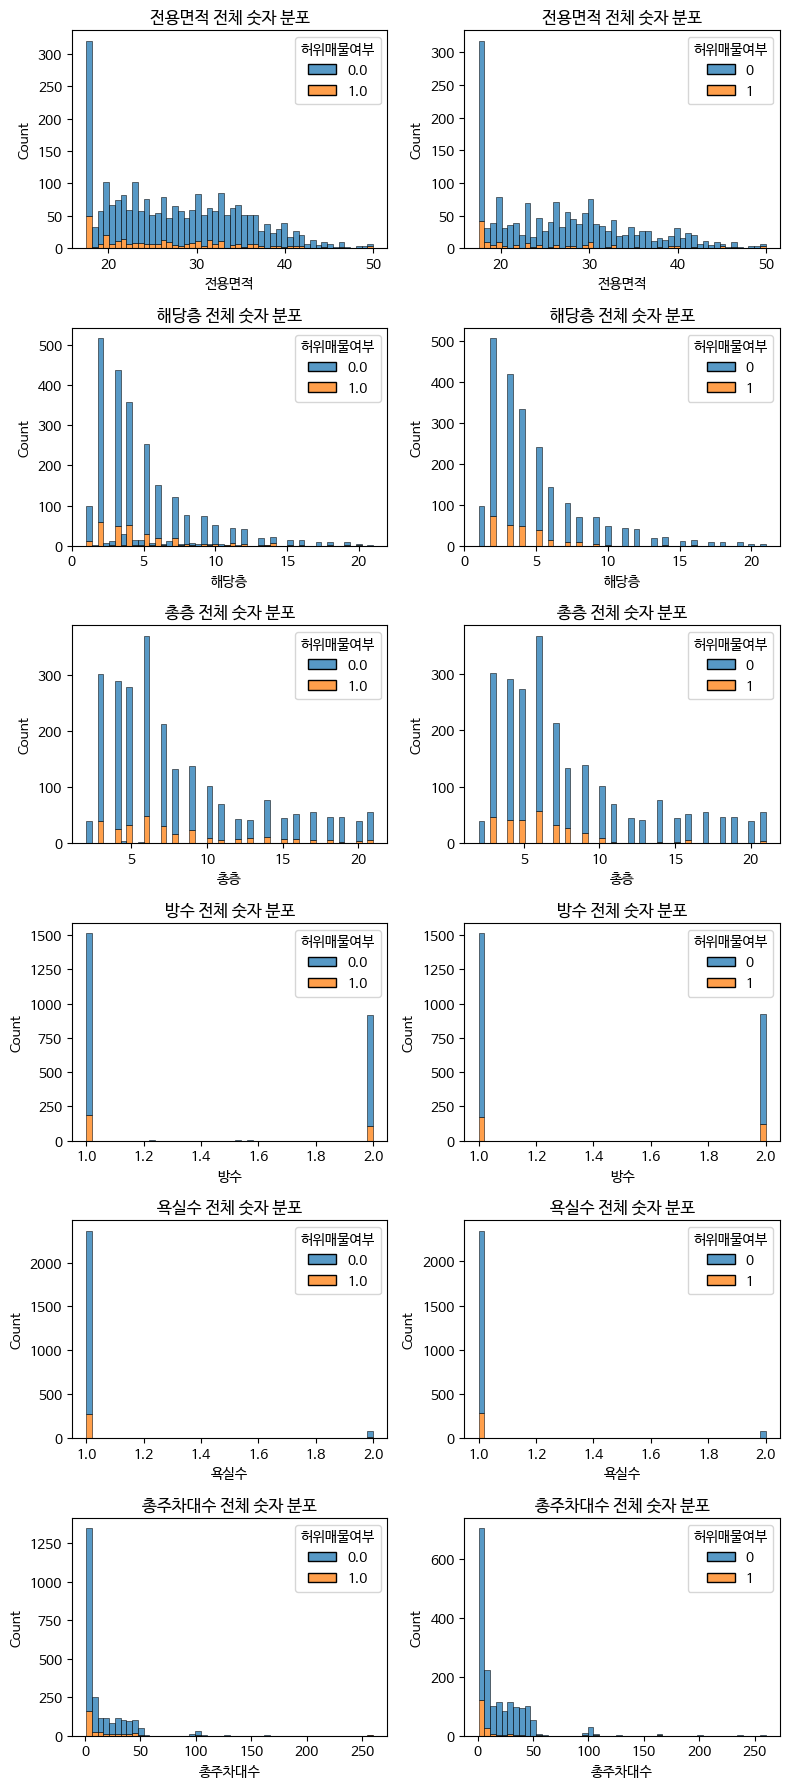

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='NanumBarunGothic')

# 결측값
continuous_features = [ '전용면적', '해당층', '총층', '방수', '욕실수', '총주차대수']

#  행과 열 개수
n_rows = len(continuous_features)
n_cols =

# 서브플롯 생성 (n_rows x 2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows))

# 변수 개수만큼 히스토그램 & 박스플롯 그리기
for i, feature in enumerate(continuous_features):
    # 🎯 히스토그램 (왼쪽 열) - 허위매물 여부 색상 구분
    sns.histplot(data=pd.concat([X_train, y_train], axis=1) ,x=feature, bins=50, kde=False, hue="허위매물여부", multiple="stack", ax=axes[i,0])
    axes[i,0].set_title(f'{feature} 전체 숫자 분포')

# 변수 개수만큼 히스토그램 & 박스플롯 그리기
for i, feature in enumerate(continuous_features):
    # 🎯 히스토그램 (왼쪽 열) - 허위매물 여부 색상 구분
    sns.histplot(data=data, x=feature, bins=50, kde=False, hue="허위매물여부", multiple="stack", ax=axes[i,1])
    axes[i,1].set_title(f'{feature} 전체 숫자 분포')


# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
X_train

,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,총주차대수,관리비,중개사무소,제공플랫폼,게재일,매물확인방식_서류확인,매물확인방식_전화확인,매물확인방식_현장확인,주차가능여부_가능,주차가능여부_불가능
0,170500000.0,200000.0,38.4969,3.00,4.0,0.0,2.0,1.0,2.05,0.0,228.0,3.0,472.0,0.0,0.0,1.0,0.0,1.0
1,114000000.0,380000.0,24.2172,2.00,3.0,3.0,1.0,1.0,1.06,0.0,150.0,0.0,444.0,0.0,1.0,0.0,0.0,1.0
2,163500000.0,30000.0,36.3000,3.00,9.0,0.0,2.0,1.0,13.00,10.0,31.0,0.0,442.0,0.0,0.0,1.0,1.0,0.0
3,346000000.0,530000.0,33.2700,3.00,3.0,3.0,2.0,1.0,1.99,0.0,72.0,1.0,288.0,0.0,0.0,1.0,0.0,1.0
4,153000000.0,530000.0,29.5000,2.03,3.0,2.0,2.0,1.0,1.00,0.0,87.0,0.0,367.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,159000000.0,550000.0,48.9500,3.00,3.0,2.0,2.0,1.0,2.71,0.0,162.0,1.0,432.0,1.0,0.0,0.0,0.0,1.0
2446,158500000.0,750000.0,20.5692,2.00,4.0,2.0,1.0,1.0,1.79,2.0,174.0,0.0,391.0,1.0,0.0,0.0,0.0,1.0
2447,329000000.0,610000.0,17.5000,8.00,20.0,1.0,1.0,1.0,29.00,10.0,31.0,1.0,248.0,0.0,1.0,0.0,1.0,0.0
2448,31000000.0,400000.0,22.8700,8.00,9.0,0.0,2.0,1.0,11.74,8.0,207.0,1.0,330.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
X_test

,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,총주차대수,관리비,중개사무소,제공플랫폼,게재일,매물확인방식_서류확인,매물확인방식_전화확인,매물확인방식_현장확인,주차가능여부_가능,주차가능여부_불가능
0,223000000.0,530000.0,22.726,5.00,5.0,2.0,1.0,1.0,3.95,7.0,145.0,3.0,406.0,1.0,0.0,0.0,0.0,1.0
1,150500000.0,590000.0,30.260,7.00,11.0,7.0,1.0,1.0,16.00,11.0,31.0,3.0,25.0,1.0,0.0,0.0,0.0,1.0
2,47000000.0,200000.0,41.500,2.00,3.0,1.0,2.0,1.0,3.26,0.0,72.0,1.0,209.0,0.0,0.0,1.0,0.0,1.0
3,133000000.0,250000.0,31.350,5.00,6.0,2.0,2.0,1.0,5.11,5.0,12.0,1.0,374.0,1.0,0.0,0.0,1.0,0.0
4,108000000.0,380000.0,23.140,2.00,3.0,2.0,1.0,1.0,1.38,0.0,142.0,0.0,426.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,152500000.0,340000.0,30.830,4.00,6.0,0.0,1.0,1.0,1.00,2.0,192.0,0.0,379.0,0.0,0.0,1.0,1.0,0.0
609,226500000.0,750000.0,29.880,6.96,10.0,1.0,2.0,1.0,34.00,7.0,232.0,1.0,359.0,0.0,1.0,0.0,1.0,0.0
610,169500000.0,500000.0,30.730,5.00,6.0,2.0,1.0,1.0,33.00,6.0,31.0,5.0,226.0,0.0,0.0,1.0,0.0,1.0
611,180000000.0,340000.0,17.500,3.00,6.0,0.0,1.0,1.0,2.00,8.0,51.0,2.0,433.0,0.0,0.0,1.0,1.0,0.0


In [ ]:
y_train

,허위매물여부
1,0
2,0
3,0
4,1
5,0
...,...
2447,0
2448,0
2449,0
2450,0
